In [240]:
# If you need to import any of the libraries, run theh below commands
#!pip3 install pandas
#!pip3 install numpy
#!pip3 install scikit-learn
#!pip3 install matplotlib

# Import Libraries & Set Up Environment

In [78]:
from sklearn.model_selection import train_test_split # Split dataset into train and validation
from sklearn.metrics import log_loss # Binary Crossentropy Loss function (fit for classification applications)
from sklearn.ensemble import RandomForestClassifier # change this to XGBoost later for better sampling
import pandas as pd # Access & modify dataframes
import numpy as np # Linear Algebra & Multiprocessing in Arrays
import matplotlib.pyplot as plt # Graph data
import os, warnings, sys

warnings.filterwarnings("ignore")

# Set up environment
SEED = 31514
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Get data from csv to pandas DataFrame
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

# Feature Engineering

**Feature engineering** is an essential step in training any AI model. If the input features are not meaningful/relevant to the output label, the AI model will be thrown off trying to find relation between features and labels when there is none; compromising the model performance. To prevent this, we need to engineer meaningful features that gives us proper information about the output.

In the case of the titanic, it's common knowledge that first and second class women and children were priviledged towards survival. These passengers were settled on higher floors, closer to the surface of the ship and lieboats. If we can determine what floor the passenger was on (gives away their proximity to the lifeboats), we can deduce a new information that gives us more information on whether a particular passenger survived, or not.

We can learn the floor of passenger cabin by getting the first character from the "Cabin" feature from all entries. (This is currently commented out since it lowered mutual information unlike expected)

We could also get the total count of parents, children, relatives on the ship along with a particular passenger. Related passengers are more likely to survive along with one another.

I've also created two binary features, one determining if the passenger is a child (below 12 years of age) and the other determines if a passenger is a parent.

In [145]:
# Change dataframe to engineer useful features
def filter_dataframe(dataframe):
    df_ = dataframe.copy()
    df_ = df_.fillna(-1)
    # Remove irrelevant features form dataframe and add temporary features
    df_["LastName"] = df_["Name"].apply(lambda x: x.split(",")[0])
    df_["FamilyIdent"] = df_["LastName"] + "---" +  df_["Ticket"]
    _ = df_.pop("PassengerId")
    _ = df_.pop("Name")
    _ = df_.pop("Ticket")
    # Add new (more relevant features)
    # Relations
    df_["Related"] = df_["SibSp"] + df_["Parch"]
    _ = df_.pop("SibSp")
    _ = df_.pop("Parch")
    # Floor Level
    #df_["Cabin"] = df_["Cabin"].apply(lambda x: str(x) if x != -1 else "U")
    #df_["Floor"] = df_["Cabin"].apply(lambda x: x[0])
    #_ = df_.pop("Cabin")
    # Child
    df_["Child"] = df_["Age"].apply(lambda x: -1 if float(x) < 0 else 1 if float(x) <= 10 else 0)
    # Parenthood
    children = df_.loc[df_["Child"] == 1,:]
    has_children = np.array(df_["FamilyIdent"].apply(lambda x: children["FamilyIdent"].isin([x]).any()), dtype=np.int64)
    adult = np.array(df_["Age"] > 20, dtype=np.int64)
    is_parent = has_children * adult
    df_["IsParent"] = is_parent
    # Remove temporary features
    _ = df_.pop("LastName")
    _ = df_.pop("FamilyIdent")
    # Get y label
    label = None
    try:
        label = df_.pop("Survived")
    except:
        pass
    return df_, label

# Replace non-numeric column types with numerical substitution
def numerize_dataframe(dataframe):
    for colname in dataframe.select_dtypes("object"):
        dataframe[colname], _ = dataframe[colname].factorize()
    return dataframe

X, y = filter_dataframe(train)
X = numerize_dataframe(X)

# Mutual Information

**MI (Mutual Information)** tells us to what extent is a particular feature related to the output/label. It tells us that, if we knew the value for that feature, how likely do we know or correctly guess the output based on that sole information.

Below is a list of all the features in the dataset (after feature engineering) and their corresponding MI scores:

In [147]:
# Find Discrete/Enumerated Features
discrete_features = X.dtypes == np.int64

# Get mutual information score for each feature
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X,y,discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="Mutual Information", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

Cabin       0.165236
Sex         0.150870
Fare        0.142952
Pclass      0.058107
Related     0.047781
Embarked    0.016668
Child       0.010006
Age         0.004866
IsParent    0.000003
Name: Mutual Information, dtype: float64


And here's the graph of how many passengers died/survived based on each feature:

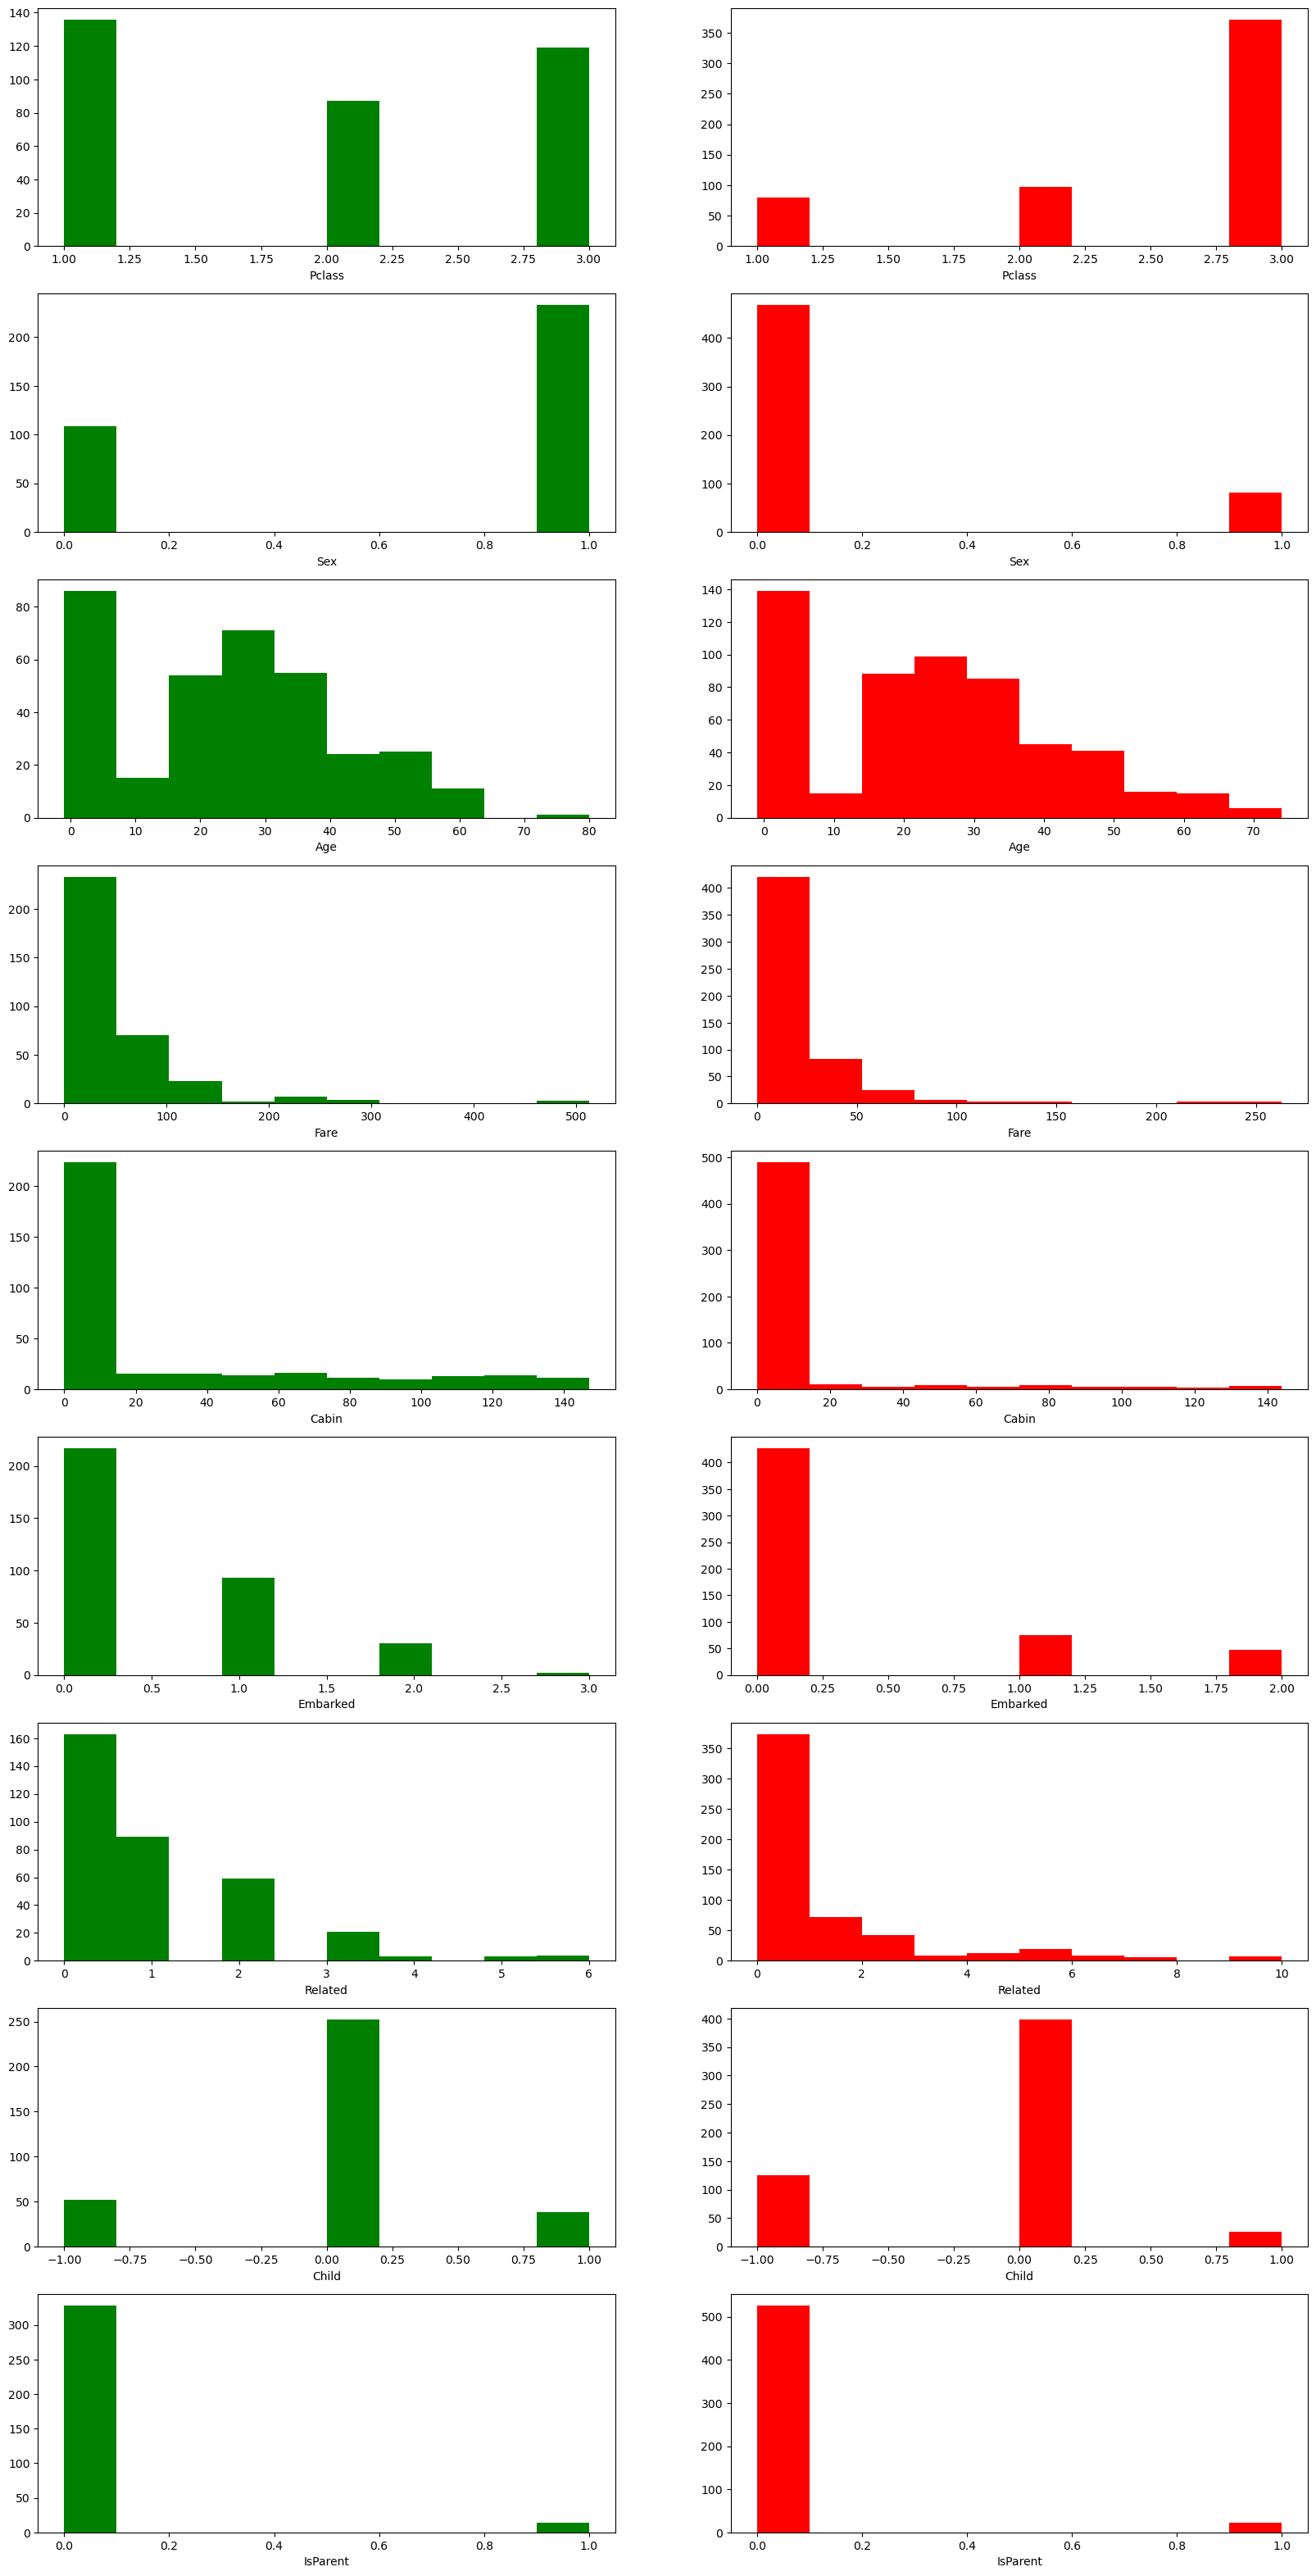

In [160]:
idx_survived = list(np.where(y == 1))[0]
idx_dead = list(np.where(y == 0))[0]

fig, axis = plt.subplots(len(X.columns),2, figsize=(20,40))
for idx, ft in enumerate(X.columns):
    # Get current subplot ax
    ax1 = axis[idx,0]
    ax2 = axis[idx,1]
    # Retrieve features from dataframe
    xlist_survived = X.loc[idx_survived, ft]
    xlist_dead = X.loc[idx_dead, ft]
    # Scatter features on subplot
    ax1.hist(xlist_survived, color='green')
    ax2.hist(xlist_dead, color='red')
    ax1.set_xlabel(ft)
    ax2.set_xlabel(ft)
plt.show()


In [197]:
# Produce our training and validation sets for optimizing model
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)

# Model 1: Random Forest

**Random forests** create an ensemble of trees that are each trained with a different sample set from the original dataset. Instead of a single decision tree coming up with an answer, we take the consensus form a collection/ensemble of trees, each making its own decision.

In [77]:
def mean_error_cost(n_nodes,train_X,train_y,val_X,val_y):
    tmp_model = RandomForestClassifier(max_leaf_nodes=n_nodes,random_state=0)
    tmp_model.fit(train_X,train_y)
    # Compute loss on validation data
    y_hat = tmp_model.predict(val_X)
    cost = log_loss(val_y,y_hat)
    return tmp_model, cost

def get_accuracy(model, val_X, val_y):
    # Prediction (convert to numpy array)
    y_hat = np.array(model.predict(val_X))
    label = np.vectorize(lambda y: 1 if y >= 0.5 else 0)
    y_pred = label(y_hat)
    y_pred = y_pred.astype(np.int32)
    # True labels (convert to numpy array)
    y_true = np.array(val_y, dtype=np.int32)
    # Get count of total correct predctions
    correct = np.equal(y_pred, y_true)
    correct_count = np.count_nonzero(correct == True)
    # Compute and return accuracy
    accuracy = correct_count/len(y_pred)
    return accuracy

def optimize_nodes(nodes):
    best_nodes = -1
    least_cost = 0
    best_model = None
    print("Optimizing nodes... (might take up to 2 minutes)")
    for node in nodes:
        tmp_model, total_cost = mean_error_cost(node,train_X,train_y,val_X,val_y)
        if total_cost < least_cost or best_nodes == -1:
            best_nodes = node
            least_cost = total_cost
            best_model = tmp_model
            
    return best_nodes, best_model, least_cost
        

In [79]:
test_nodes = list(range(2,100))

best_n_node, best_model, best_node_cost = optimize_nodes(test_nodes)
print(f"Best # nodes: {best_n_node}, best loss: {best_node_cost}")

Optimizing nodes... (might take up to 2 minutes)
Best # nodes: 25, best loss: 7.596644436271329


# Model 2: XGBoost Classifier

This method is highly used, but there's a problem with using Random Forests, **which is that they're random**. The input sample set is produced randomly, giving it the name. However, if we were to sample the examples that were guessed to be wrong by the previous tree, that would give us a more accurate ensemble. That's where **XGBoost Trees** come into play.

In the example below, **XGBoost Classifier** does just that and notably increases the accuracy of our model. With each iteration of a new tree, by emphasizing the mislabelled examples, it produces a new tree in the ensemble that covers the vulnerability of the previous.

In [199]:
!pip3 install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def compile_xgb(n_estimators=500,learning_rate=0.05,gamma=0,lambda_=0,alpha=0):
    xgb_clf = XGBClassifier(n_estimators = n_estimators, # Number of trees in the model
                            learning_rate = learning_rate,
                            booster = 'gbtree',
                            eval_metric = 'logloss',
                            importance_type = 'gain',
                            early_stopping_rounds = 5, # Min. amout of rounds before early stopping
                            n_jobs = -1, # How many parallel threads to train the model on (-1 defaults to 'all available')
                            max_depth = len(train_X.columns),
                            colsample_bytree = 1,
                            colsample_bylevel = 1,
                            min_child_weight = 1,
                            gamma = gamma,
                            reg_lambda = lambda_,
                            reg_alpha = alpha
                        )
    return xgb_clf

def train_xgb(xgb_model, train_X, train_y, val_X, val_y):
    xgb_model.fit(train_X, train_y,                    
                eval_set = [(val_X,val_y)],
                verbose = False)

def xgb_model_acc(model):
    train_pred = model.predict(train_X)
    test_pred = model.predict(val_X)
    train_acc = accuracy_score(train_pred, train_y)
    test_acc = accuracy_score(test_pred, val_y)
    return train_acc, test_acc

xgb_model = compile_xgb()
train_xgb(xgb_model,train_X,train_y,val_X,val_y)
train_acc, test_acc = xgb_model_acc(xgb_model)
print(f"XGB Train Accuracy Pre-Optimizaiton: {100*np.round(train_acc, 2)}%, Test Accuracy: {100*np.round(test_acc, 2)}%")

Defaulting to user installation because normal site-packages is not writeable
XGB Train Accuracy Pre-Optimizaiton: 92.0%, Test Accuracy: 80.0%


# Optimization

Optimizing our model is an essential step to increase accuracy. The model structure has to fit the context of our application, or our intent.

### Hyper-parameter optimization:

**Hyper-parameter optimization** is the step of trying out different **hyper-parameters** (parameters that determine the structure and training of our model), and picking out the values that fit the best. A few things to consider:

 - `max_depth`: Is the hyper-parameter that determines the maximum depth a decision tree can reach. Smaller values work better with regularization, and prevents overfitting in a tree ensemble.
 - `n_estimators`: Determines the number of trees in an emsemble. The more trees, the higher the accuracy. However, excessively high values can turn the model prone to overfitting. To prevent this, it is recommended to use a learning_rate threshold so that when the gain of accuracy from one addition of tree becomes insignificant, you can stop the optimization.

### Regularization parameters:
 - `gamma`: Gamma is a special regularization parameter for decision tree ensembles. Regularization parameters can drive overfitting weights to near-zero values so that the model fits the trend, instead of memorizing the training data.
 - `lambda`: Also a regularization parameter that is used in many applications of **Supervised Learning**. It drives the training weights of an overfitting node (neuron in Neural Networks) to near zero and captures the trend instead of memorizing the training examples.

In [201]:
def optimize_estimators(estimator_list,min_learn_rate=0.00001):
    best_n_estimator = -1
    best_acc = 0
    for estimator in estimator_list:
        model = compile_xgb(n_estimators=estimator)
        train_xgb(model,train_X,train_y,val_X,val_y)
        train_acc, test_acc = xgb_model_acc(model)
        if abs(test_acc - best_acc) < min_learn_rate:
            return best_n_estimator, best_acc
        if test_acc > best_acc or best_n_estimator == -1:
            best_n_estimator = estimator
            best_acc = test_acc
    return best_n_estimator, best_acc

estimators = list(range(200,15000,100))
n_estimators, estimator_acc = optimize_estimators(estimators)
print(n_estimators, estimator_acc)

200 0.7982062780269058


In [204]:
def optimize_gamma(gammas):
    best_gamma = -1
    best_acc = 0
    for gamma in gammas:
        model = compile_xgb(n_estimators=n_estimators,gamma=gamma)
        train_xgb(model,train_X,train_y,val_X,val_y)
        train_acc, test_acc = xgb_model_acc(model)
        if test_acc > best_acc or best_gamma == -1:
            best_gamma = gamma
            best_acc = test_acc
    return best_gamma, best_acc
    
gammas = np.arange(0,0.01,0.001)
gamma, gamma_acc = optimize_gamma(gammas)
print(gamma, gamma_acc)

0.0 0.7982062780269058


In [206]:
def optimize_lambda(lambdas):
    best_reg = -1
    best_acc = 0
    for lambda_ in lambdas:
        model = compile_xgb(n_estimators=n_estimators,gamma=gamma,lambda_=val)
        train_xgb(model,train_X,train_y,val_X,val_y)
        train_acc, test_acc = xgb_model_acc(model)
        if test_acc > best_acc or best_reg == -1:
            best_reg = lambda_
            best_acc = test_acc
    return best_reg, best_acc

lambdas = np.arange(0,1,0.01)
lambda_, lambda_acc = optimize_reg(lambdas)
print(lambda_, lambda_acc)

0.3 0.8026905829596412


Here's the final traning and test accuracies of our model after optimization:

In [209]:
optimized_model = compile_xgb(n_estimators=n_estimators,gamma=gamma,lambda_=lambda_)
train_xgb(optimized_model,train_X,train_y,val_X,val_y)
opt_train_acc, opt_test_acc = xgb_model_acc(optimized_model)
print(f"XGB Train Accuracy After Optimization: {100*np.round(opt_train_acc, 4)}%, Test Accuracy: {100*np.round(opt_test_acc, 4)}%")

XGB Train Accuracy After Optimization: 91.62%, Test Accuracy: 80.27%


# Train Final Model

Now that we've optimized our **XGBClassifier** model, we can train it on all of our labelled dataset. After this step, we'll run predictions for the **unlabelled** test dataset, and save the results in a **.csv** file.

In [212]:
final_model = compile_xgb(n_estimators=n_estimators,gamma=gamma,lambda_=lambda_)
train_xgb(final_model,X,y,val_X,val_y,)
train_acc, test_acc = xgb_model_acc(final_model)
print(f"Validation is also trained upon so test accuracy is biased. Train acc:  {100*np.round(train_acc, 4)}%, Test Acc: {100*np.round(test_acc, 4)}")

Validation is also trained upon so test accuracy is biased. Train acc:  97.00999999999999%, Test Acc: 96.41


# Predicting Labels for Testing Set and Saving Results

In [219]:
X_t, _ = filter_dataframe(test)
X_t = numerize_dataframe(X_t)

In [231]:
def log_test_labels(model,target_name):

    ids = list(test["PassengerId"])
    predictions = list(model.predict(X_t))

    submit_data = {
        "PassengerId": ids,
        "Survived": predictions
    }

    submit_df = pd.DataFrame(submit_data)
    submit_df = submit_df.set_index("PassengerId")
    submit_df.to_csv(f"{target_name}.csv")
    print(f"Test dataset label predictions logged in directory {os.getcwd()}/{target_name}.csv")

log_test_labels(final_model,"titanic_xgboost_pred")

Test dataset label predictions logged in directory C:\Users\Owner\Desktop\Kaggle\titanic/titanic_xgboost_pred.csv


# A Better Way to Optimize: GridSearchCV

`scikit-learn` has a built-in method that conveniently optimizes an XGBoost model for any specified parameter. **GridSearchCV** takes your model, and a dictionary of optimizing parameters as input. It returns an optimized model you can train and save.

In comparison to all the code we wrote down previously, here's how long it takes using **GridSearchCV**:

In [234]:
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

sample_model = XGBClassifier(n_estimators=500)

param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200),
    'reg_lambda': stats.uniform(0.001,0.01),
    'gamma': stats.uniform(0,10)
}

# Optimize XGBoost model
grid_search = GridSearchCV(sample_model, param_grid, cv=5, scoring='accuracy')
# Train model with labelled dataset
grid_search.fit(X,y)
# Display the best score produced by the model.
print(grid_search.best_score_)

0.8496076831335133


Now, let's save the predictions drawn by our model optimized using **GridSearchCV**:

In [242]:
log_test_labels(grid_search,"titanic_gridsearch_pred")

Test dataset label predictions logged in directory C:\Users\Owner\Desktop\Kaggle\titanic/titanic_gridsearch_pred.csv
